In [34]:
import numpy as np
import pandas as pd

import gc
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from nltk.corpus import stopwords
stop = stopwords.words('english')

gc.enable()

In [2]:
data = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")

In [3]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom

In [4]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [5]:
for col in data.columns:
    if np.any(data[col].isna()):
        print(col)
        num_missing = data[col].isna().sum()
        print(num_missing, num_missing / len(data))

Description
1454 0.002683107311375157
CustomerID
135080 0.249266943342886


In [6]:
data[data["CustomerID"].isna()].head()

InvoiceNo StockCode                      Description  Quantity  \
622     536414     22139                              NaN        56   
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445    536544     21786               POLKADOT RAIN HAT          4   
1446    536544     21787            RAIN PONCHO RETROSPOT         2   

             InvoiceDate  UnitPrice  CustomerID         Country  
622  2010-01-12 11:52:00       0.00         NaN  United Kingdom  
1443 2010-01-12 14:32:00       2.51         NaN  United Kingdom  
1444 2010-01-12 14:32:00       2.51         NaN  United Kingdom  
1445 2010-01-12 14:32:00       0.85         NaN  United Kingdom  
1446 2010-01-12 14:32:00       1.66         NaN  United Kingdom

In [7]:
# fill description if data available from other purchases
stock_to_desc = data.loc[data["Description"].isna(), "StockCode"].unique()
non_null_desc = data.loc[data["StockCode"].isin(stock_to_desc), ["StockCode", "Description"]]
non_null_desc = non_null_desc.groupby("StockCode").agg({"Description": lambda x: x.values[0]})["Description"].to_dict()
data.loc[data["Description"].isna(), "Description"] = data.loc[data["Description"].isna(), "StockCode"].map(non_null_desc)

In [8]:
data.dropna(inplace=True)
del stock_to_desc, non_null_desc; gc.collect()

0

In [9]:
data[data["Quantity"] <= 0]  
# goods returned to the store or outliers? - drop or 
# define new feature: "returned_discout" agg by sum
# set UnitPrice *= -1

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  
141    2010-01-12 09:41:00      27.50     14527.0  United Kingdom  
154    2010-01-12 09:49:00       4.65     15311.0  United Kingdom  
235    2010-01-12 10:24:00       1.65     17548.0  United Kingdom  
236    2010-01-12 10:24:00       0.29     17548.0  United Kingdom  
237    2010-01-12 10:24:00       0.29     17548.0  United Kingdom  
...                    ...        ...         ...             ...  
540449 2011-09-12 09:57:00       0.83     14397.0  United Kingdom  
541541 2011-09-12 10:28:00     224.69     15498.0  United Kingdom  
541715 2011-09-12 11:57:00      10.95     15311.0  United Kingdom  
541716 2011-09-12 11:58:00       1.25     17315.0  United Kingdom  
541717 2011-09-12 11:58:00       1.25     17315.0  United Kingdom  

[8905 rows x 8 columns]

In [10]:
# to get closer ti normal
# data["UnitPrice"] = np.log1p(data["UnitPrice"])

# for distance-based algorithms it is strongly recommended to remove outliers
# data["UnitPrice"] = np.clip(data["UnitPrice"], 0, a_max=np.percentile(data["UnitPrice"], 99.7))  # ~3-sigma
data["UnitPrice"] = np.clip(data["UnitPrice"], a_min=data["UnitPrice"].quantile(0.05), a_max=data["UnitPrice"].quantile(0.95))
# to prevent quantity shift due to gifts, let's just remove them (zero-price have a high quantity)
# data = data[data["UnitPrice"] != 0]
data = data[(data["UnitPrice"] != 0) & (data["Quantity"] > 0)]  # remove negative and zero values

<AxesSubplot:>

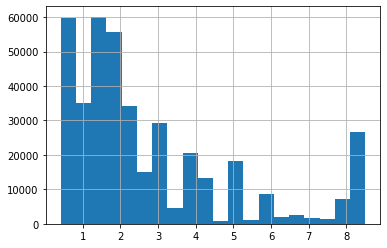

In [11]:
# K-Means likes normal distribution: here the distribution is not normal, but closer than before
data["UnitPrice"].hist(bins=20)

In [8]:
# set price < 0 if goods were returned or discount applied
# data.loc[data["Quantity"] < 0, "UnitPrice"] *= (-1)

In [108]:
# data[(data["Quantity"] < -1000) | (data["Quantity"] > 1000)]

InvoiceNo StockCode                          Description  Quantity  \
4287     C536757     84347  ROTATING SILVER ANGELS T-LIGHT HLDR     -9360   
4850      536809     84950       ASSORTED COLOUR T-LIGHT HOLDER      1824   
4945      536830     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS      2880   
4946      536830     21915               RED  HARMONICA IN BOX       1400   
6365      536890    17084R                ASSORTED INCENSE PACK      1440   
...          ...       ...                                  ...       ...   
534952    581175     23084                   RABBIT NIGHT LIGHT      1440   
540070    581458     22197                       POPCORN HOLDER      1500   
540071    581459     22197                       POPCORN HOLDER      1200   
540421    581483     23843          PAPER CRAFT , LITTLE BIRDIE     80995   
540422   C581484     23843          PAPER CRAFT , LITTLE BIRDIE    -80995   

               InvoiceDate  UnitPrice  CustomerID         Country  
4287   2010-02-12 14:23:00  -0.029559     15838.0  United Kingdom  
4850   2010-02-12 16:48:00   0.438255     15299.0  United Kingdom  
4945   2010-02-12 17:38:00   0.165514     16754.0  United Kingdom  
4946   2010-02-12 17:38:00   0.722706     16754.0  United Kingdom  
6365   2010-03-12 11:48:00   0.148420     14156.0            EIRE  
...                    ...        ...         ...             ...  
534952 2011-07-12 15:16:00   1.026042     14646.0     Netherlands  
540070 2011-08-12 18:45:00   0.542324     17949.0  United Kingdom  
540071 2011-08-12 18:46:00   0.542324     17949.0  United Kingdom  
540421 2011-09-12 09:15:00   1.124930     16446.0  United Kingdom  
540422 2011-09-12 09:27:00  -1.124930     16446.0  United Kingdom  

[117 rows x 8 columns]

In [9]:
# data = data[~data["Quantity"].isin([-80995., 80995., -74215.0, 74215.0])]  # remove extreme values

# data["returned_discount"] = np.where(data["Quantity"].values < 0, 1, 0).astype(np.uint8)  # add return_disc flag

In [12]:
# not the best decision: we can get quantity and price shift for customers which bought and returned goods partly
# data["Quantity"] = np.clip(data["Quantity"], a_min=1, a_max=np.percentile(data["Quantity"], 99.7))
data["Quantity"] = np.clip(data["Quantity"], a_min=data["Quantity"].quantile(0.05), a_max=data["Quantity"].quantile(0.95))

In [13]:
# data["total_amount_bought"] = data["Quantity"] * np.expm1(data["UnitPrice"])
data["total_amount_bought"] = data["Quantity"] * data["UnitPrice"]

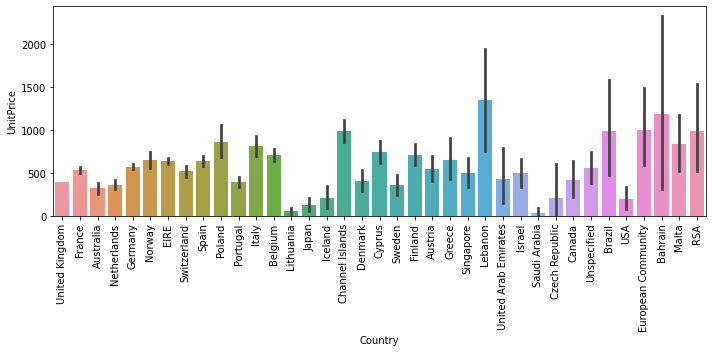

In [14]:
plt.figure(figsize=(10, 5))
sns.barplot(x=data["Country"], y=np.expm1(data["UnitPrice"]))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

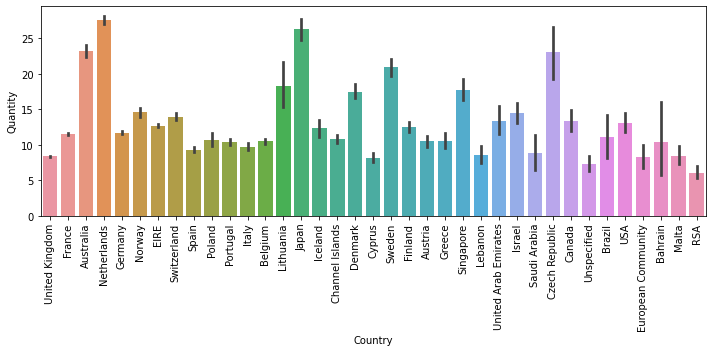

In [15]:
plt.figure(figsize=(10, 5))
sns.barplot(x=data["Country"], y=data["Quantity"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
data["month"] = data["InvoiceDate"].dt.month
data["day"] = data["InvoiceDate"].dt.day
data["year"] = data["InvoiceDate"].dt.year
data["month_day"] = data["month"].astype(str) + "_" + data["day"].astype(str)

In [17]:
# days customer active
cust_inv = data.groupby(["CustomerID", "InvoiceNo"]).agg({"InvoiceDate": "last"}).reset_index()
cust_inv = cust_inv.groupby("CustomerID").agg({"InvoiceDate": lambda x: (x.max() - x.min()).days}).reset_index()
cust_inv = cust_inv.rename(columns={"InvoiceDate": "days_from_birth"})
data = data.merge(cust_inv, on=["CustomerID"], how="left")

In [18]:
# mean number of days between purchases
cust_inv = data.groupby(["CustomerID", "InvoiceNo"]).agg({"InvoiceDate": "last"}).reset_index()
cust_inv= cust_inv.groupby("CustomerID").agg({"InvoiceDate": lambda x: (x.max() - x.min()).days / len(x)}).reset_index()
cust_inv = cust_inv.rename(columns={"InvoiceDate": "mean_days_for_purchase"})
data = data.merge(cust_inv, on=["CustomerID"], how="left")

In [19]:
# number of days between every customer purchase
temp = data.groupby("InvoiceNo")["mean_days_for_purchase"].last()
cust_inv = data.groupby(["CustomerID", "InvoiceNo"]).agg({"InvoiceDate": "last"}).reset_index().sort_values(["CustomerID", "InvoiceDate"])
cust_inv["diff"] = cust_inv["InvoiceDate"].diff(1).astype(str).str.split().str[0].replace("NaT", -1).astype(int)
cust_inv.drop("InvoiceDate", axis=1, inplace=True)
cust_inv.loc[cust_inv["diff"] < 0, "diff"] = cust_inv.loc[cust_inv["diff"] < 0, "InvoiceNo"].map(temp).astype(int)
data = data.merge(cust_inv, on=["CustomerID", "InvoiceNo"], how="left")
del temp, cust_inv; gc.collect()

19641

In [20]:
data["last_purchase"] = (data["InvoiceDate"].max() - data["InvoiceDate"]).dt.days

In [21]:
# data["total_amount_bought"] = np.clip(data["total_amount_bought"], 0, np.percentile(data["total_amount_bought"], 99.7))
data["total_amount_bought"] = np.clip(data["total_amount_bought"], data["total_amount_bought"].quantile(0.05), 
                                      data["total_amount_bought"].quantile(0.95))

In [22]:
data[["total_amount_bought", "Quantity", "UnitPrice"]].describe()

total_amount_bought       Quantity      UnitPrice
count        397924.000000  397924.000000  397924.000000
mean             14.378155       8.868437       2.675558
std              12.576208       9.524082       2.275051
min               1.250000       1.000000       0.420000
25%               4.950000       2.000000       1.250000
50%              11.250000       6.000000       1.950000
75%              17.700000      12.000000       3.750000
max              50.400000      36.000000       8.500000

In [23]:
# frequency encoding
vcnt = data["Country"].value_counts() 
data["Country"] = data["Country"].map(vcnt)

temp = data["month_day"].value_counts(normalize=True)
data["month_day"] = data["month_day"].map(temp)

# Label encoding
data["StockCode"] = LabelEncoder().fit_transform(data["StockCode"])

# not needed any more
data.drop("InvoiceDate", axis=1, inplace=True)
del temp, vcnt; gc.collect()

0

In [24]:
# clean text data
def preprocessor(text, stop=stop):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text)
    text = re.sub(r'[^\w]', ' ', text)
    text = [w for w in text.split() if w not in stop]
    text = [re.sub(r"[^a-zA-Z0-9]+", '', k) for k in text]
    return re.sub(' +', ' ', ' '.join(text))

In [25]:
data["Description"] = data["Description"].apply(preprocessor)

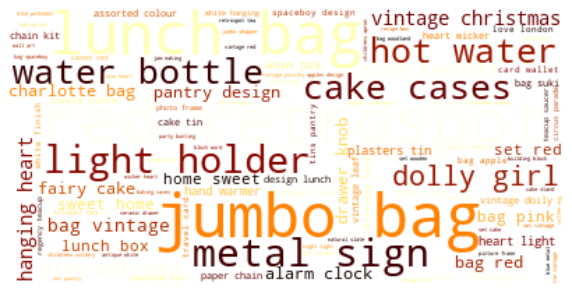

In [28]:
# description wordcloud
from wordcloud import WordCloud

data_words = data["Description"].str.cat(sep='\n')
word_cloud_plt = WordCloud(collocation_threshold=2, 
                           collocations=True, 
                           background_color='white',
                           stopwords=stop,
                           colormap='afmhot').generate(data_words)

plt.figure(figsize=(10,10))
plt.imshow(word_cloud_plt, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
from typing import Optional


def read_corpus(series, tokens_only=False):
    for i, tokens in enumerate(series):
        tokens = gensim.utils.simple_preprocess(tokens)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            
            
def aggregate_docs(doc_array, func=np.mean):
    aggr = np.empty((doc_array.shape[0], 20))
    for i, doc in enumerate(doc_array):
        aggr[i, :] = model.infer_vector(doc.split())
    return func(aggr, axis=0)


def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [30]:
train_corpus = list(read_corpus(data["Description"].unique()))

In [31]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=20, min_count=2, epochs=40, window=1, hs=0, 
                                      negative=2, alpha=0.03, min_alpha=0.0007, seed=42)
model.build_vocab(train_corpus)

model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [35]:
desc_features = np.empty((data.shape[0], 20))

for i, doc in tqdm(enumerate(data["Description"])):
    desc_features[i, :] = model.infer_vector(doc.split())

397924it [03:38, 1824.49it/s]


In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pca = make_pipeline(StandardScaler(), PCA(n_components=None, random_state=42)).fit(desc_features)

pca[-1].explained_variance_ratio_.cumsum()

array([0.23090579, 0.42073855, 0.5167607 , 0.60415754, 0.65857757,
       0.70495745, 0.74905338, 0.78591861, 0.81981509, 0.85246009,
       0.87742404, 0.90023453, 0.91896483, 0.93547774, 0.95017558,
       0.96307713, 0.97514275, 0.98514353, 0.99448041, 1.        ])

In [37]:
del desc_features; gc.collect()

1993

In [41]:
aggs = {
    "InvoiceNo": [("_UNIQUE_PURCHASES_", lambda x: x.nunique())],
    "StockCode": ["mean", ("_MODE_", lambda x: x.mode()[0]), "last"],
    "Description": [aggregate_docs],
    "Quantity": ["sum", "max", "min", "std"],
    "UnitPrice": ["sum", "min", "max", "std", "count"],
    "Country": ["last"],
    "total_amount_bought": ["sum", "mean"],
    "month": ["last", "mean"],
    "day": ["last", "mean"],
    "year": ["last", "mean"],
    "month_day": ["last", ],
    "days_from_birth": ["last"],
    "mean_days_for_purchase": ["mean"],
    "diff": ["last", "max", "min"],
    "last_purchase": ["min"],
}

In [42]:
%%time
agg_data = create_numerical_aggs(data=data, groupby_id="CustomerID", aggs=aggs, suffix="_BY_USERID")
del data; gc.collect()

CPU times: total: 3min 36s
Wall time: 3min 36s


823

In [43]:
agg_data_docs = pd.DataFrame(data=agg_data["DESCRIPTION_AGGREGATE_DOCS_BY_USERID"].values.tolist(), index=agg_data.index,
                            columns=[f"AGG_DOC_{i+1}" for i in range(20)])
agg_data = pd.concat([agg_data, agg_data_docs], axis=1)
agg_data.drop("DESCRIPTION_AGGREGATE_DOCS_BY_USERID", axis=1, inplace=True)
agg_data.fillna(0, inplace=True)
agg_data.set_index("CustomerID", inplace=True)

In [44]:
def bootstrap_sample(amounts):
    return np.random.choice(amounts, len(amounts), replace=True)

def percentile(sample,percent):
     return np.percentile(sample, percent)

def bootstrap_confidence_interval(data, percent):
    """
    Creates list of 10000 xth percentile bootstrap replicates. 
    """
    bs_samples = np.empty(10000)
    
    for i in range(10000):
        bs_samples[i] = percentile(bootstrap_sample(data),percent)

    return bs_samples

In [45]:
percentiles={
    'UNITPRICE_COUNT_BY_USERID': [],
    'TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID': [],
    'LAST_PURCHASE_MIN_BY_USERID': []
    }

for i in [20,40,60,80]:
    percentiles['UNITPRICE_COUNT_BY_USERID'].append(np.percentile(bootstrap_confidence_interval(agg_data['UNITPRICE_COUNT_BY_USERID'],i),95))
    percentiles['TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID'].append(np.percentile(bootstrap_confidence_interval(agg_data['TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID'],i),95))
    percentiles['LAST_PURCHASE_MIN_BY_USERID'].append(np.percentile(bootstrap_confidence_interval(agg_data['LAST_PURCHASE_MIN_BY_USERID'],i),95))
percentiles

{'UNITPRICE_COUNT_BY_USERID': [14.0, 30.0, 60.0, 127.0],
 'TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID': [216.35399999999998,
  429.67600000000004,
  822.3059999999998,
  1815.34],
 'LAST_PURCHASE_MIN_BY_USERID': [18.0, 45.0, 90.0, 197.0]}

In [46]:
agg_data[list(percentiles.keys())].head()

UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
CustomerID                                                                 
12346.0                             1                              37.44   
12347.0                           182                            3810.37   
12348.0                            31                             728.42   
12349.0                            73                            1380.15   
12350.0                            17                             302.90   

            LAST_PURCHASE_MIN_BY_USERID  
CustomerID                               
12346.0                             326  
12347.0                              40  
12348.0                              76  
12349.0                              19  
12350.0                             311

In [53]:
agg_data["UNITPRICE_COUNT_BY_USERID_CUT"] = pd.cut(agg_data["UNITPRICE_COUNT_BY_USERID"], 
                                                  bins=[0, 14.0, 30.0, 60.0, 126.40000000000009, 15000], labels=False)

agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID_CUT"] = pd.cut(agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                                                           bins=[0, 216.3, 429.64, 822.31,1803.28, 1000000], labels=False)

agg_data["LAST_PURCHASE_MIN_BY_USERID_CUT"] = pd.cut(agg_data["LAST_PURCHASE_MIN_BY_USERID"], 
                                                     bins=[-1000, 18.0, 45.0, 90.0, 197.0, 150000], labels=False)

#agg_data.fillna(0, inplace=True)

In [55]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [56]:
from sklearn.preprocessing import StandardScaler
rfm_df = agg_data[list(percentiles.keys())]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4339, 3)

In [80]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = list(percentiles.keys())

hopkins(rfm_df_scaled)  # high ability to cluster: 0.8832641213686452 - full data, 0.9955572799617483 for 3 cols

0.9959677139885944

In [81]:
columns_to_scale = [col for col in agg_data.columns if not col.startswith("AGG_DOC_")]
other_columns = [col for col in agg_data.columns if col not in columns_to_scale]

In [82]:
scaler = StandardScaler()  # MinMaxScaler()
agg_data[columns_to_scale] = scaler.fit_transform(agg_data[columns_to_scale])

In [83]:
scaler = StandardScaler()
agg_data[other_columns] = scaler.fit_transform(agg_data[other_columns])

In [84]:
def reduce_memory(df, verbose=0):
    if verbose != 0:
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    if verbose != 0:
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [85]:
agg_data = reduce_memory(agg_data, verbose=1)

Memory usage of dataframe is 1.75 MB
Memory usage after optimization is: 0.89 MB
Decreased by 49.1%


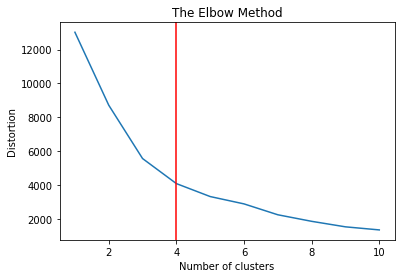

In [95]:
distortions = [] 
max_k = 10
for i in range(1, max_k+1):
    if len(rfm_df_scaled) >= i:
        model = KMeans(n_clusters=i, max_iter=300, n_init=15, random_state=421)
        model.fit(rfm_df_scaled)
        distortions.append(model.inertia_)
    

k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))


fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='-', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")

plt.show()

**Silhouette score**

Silhouette score $= \frac{p - q}{max(p, q)}$

* p - mean distance to closest cluster that the point is not part of;
* q - mean distance to all points in own cluster

In [96]:
from sklearn.metrics import silhouette_score  # [-1,1]

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, random_state=42)
    kmeans.fit(rfm_df_scaled) # agg_data[selected]
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.9365123957028104
For n_clusters=3, the silhouette score is 0.518567796715904
For n_clusters=4, the silhouette score is 0.5555172305408496
For n_clusters=5, the silhouette score is 0.5461813774730738
For n_clusters=6, the silhouette score is 0.5481510904778377
For n_clusters=7, the silhouette score is 0.5479773510804374
For n_clusters=8, the silhouette score is 0.45794748048883027


In [97]:
# perform feature selection
def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     X: pd.DataFrame,
                                     maximize: bool = True,
                                     ) -> pd.Series:
    estimator.fit(X)
    base_score = metric(X, estimator.labels_)
    scores, delta = {}, {}

    for feature in tqdm(X.columns):
        X_ = X.copy(deep=True)
        np.random.seed(42)
        X_[feature] = np.random.permutation(X_[feature])

        estimator.fit(X_)
        feature_score = metric(X_, estimator.labels_)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [98]:
scores, deltas = calculate_permutation_importance(estimator=KMeans(n_clusters=2, max_iter=100, random_state=42),
                                                  metric=silhouette_score,
                                                  X=agg_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:15<00:00,  3.29it/s]


In [99]:
selected = deltas[deltas > 0.01].index.tolist()

In [145]:
# add cluster_id and groupby cluster_id
kmeans = KMeans(n_clusters=2, max_iter=1000, n_init=15, random_state=42).fit(rfm_df_scaled)
agg_data["cluster"] = kmeans.predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, kmeans.labels_)}")
agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.9365123957028104


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
0                        -0.032022                          -0.032089   
1                        15.406114                          15.438491   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
0                           0.001750  
1                          -0.841929

In [109]:
# PCA 
pca_agg_data = PCA(n_components=None, random_state=42).fit(agg_data)

pca_agg_data.explained_variance_ratio_.cumsum()

array([0.13173918, 0.23682013, 0.31827148, 0.38959811, 0.44240873,
       0.49280249, 0.53332667, 0.57172228, 0.60897023, 0.64414964,
       0.67494609, 0.70481923, 0.73246647, 0.75556923, 0.77461091,
       0.79197556, 0.8075729 , 0.82277872, 0.83549871, 0.84775996,
       0.85959687, 0.87095053, 0.88145651, 0.89176461, 0.90101209,
       0.9097011 , 0.91792675, 0.92521558, 0.93177931, 0.93783669,
       0.94385909, 0.94957079, 0.95473706, 0.95970306, 0.96418425,
       0.96802038, 0.97168947, 0.97528601, 0.97860101, 0.9816358 ,
       0.98412716, 0.98648167, 0.98856459, 0.99056399, 0.99238601,
       0.9941589 , 0.99555913, 0.99677686, 0.99795327, 0.99885919,
       0.99951657, 0.99991899, 1.        ])

In [146]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py


Scene = dict(xaxis=dict(title='UNITPRICE_COUNT_BY_USERID'),
             yaxis=dict(title='TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID'),zaxis=dict(title='LAST_PURCHASE_MIN_BY_USERID'))

labels = kmeans.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=10, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=800, width=800)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

In [103]:
from sklearn.cluster import DBSCAN

In [147]:
dbscan = DBSCAN(eps=0.8, min_samples=10, metric='euclidean', n_jobs=-1)
agg_data["cluster"] = dbscan.fit_predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, dbscan.labels_)}")

agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.8613674580009018


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
-1                        6.742136                           6.695864   
 0                       -0.056406                          -0.056019   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
-1                         -0.585546  
 0                          0.004899

In [112]:
labels = dbscan.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=10, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=800, width=800)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

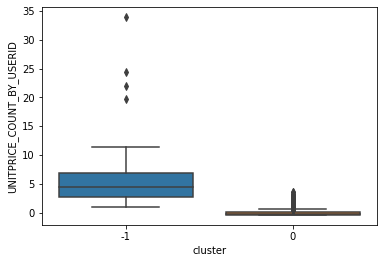

In [113]:
sns.boxplot(y="UNITPRICE_COUNT_BY_USERID", x="cluster", data=agg_data)
plt.show()

In [114]:
# considered as outliers
rfm_df_scaled[dbscan.labels_ == -1]

UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
55                     2.728946                           8.124782   
326                   19.689472                           8.285648   
445                    2.746431                           4.501266   
558                    4.092782                           6.845675   
562                    7.546085                          13.756409   
570                    2.099483                           4.927708   
691                    6.929736                           1.924786   
796                    1.688583                           4.942240   
997                    2.081998                           5.899981   
1263                   4.433741                           2.162212   
1285                   2.173794                           7.495786   
1290                  21.940676                          14.146625   
1334                   5.718894                          11.282670   
1337                   4.862125                           1.127314   
1435                   6.754885                          12.093349   
1547                   3.839248                           0.612471   
1603                   3.847991                           2.013763   
1662                  11.401545                           3.151780   
1690                   8.691357                          23.638587   
1780                   4.363801                           2.837130   
1798                   4.586735                           2.068052   
1880                  24.414814                          34.520724   
1938                   4.490567                           1.556019   
1965                   6.164764                           4.921402   
2064                   2.702718                           4.721331   
2177                   9.998367                           9.588853   
2480                   3.694996                           1.180748   
2706                   4.569250                           2.287596   
3080                   3.887332                           0.905443   
3772                   3.808649                          10.457050   
3895                   2.680862                           5.279617   
3943                   2.615293                           3.657523   
4011                  33.900470                          11.633550   
4017                   0.897384                           1.135622   
4202                   1.483134                           6.060322   
4214                   5.189970                           1.307075   

      LAST_PURCHASE_MIN_BY_USERID  
55                      -0.699011  
326                     -0.881521  
445                     -0.829375  
558                     -0.811993  
562                     -0.864139  
570                     -0.829375  
691                     -0.872830  
796                     -0.890212  
997                     -0.690320  
1263                    -0.777230  
1285                    -0.820684  
1290                    -0.811993  
1334                    -0.916284  
1337                    -0.742466  
1435                    -0.455665  
1547                    -0.716393  
1603                    -0.907593  
1662                    -0.872830  
1690                    -0.898902  
1780                    -0.194938  
1798                    -0.716393  
1880                    -0.916284  
1938                    -0.777230  
1965                    -0.829375  
2064                    -0.751157  
2177                    -0.916284  
2480                     0.404736  
2706                    -0.872830  
3080                    -0.820684  
3772                    -0.864139  
3895                    -0.890212  
3943                     0.031026  
4011                    -0.916284  
4017                     4.871869  
4202                    -0.811993  
4214                    -0.820684

**Gaussian Mixture**

In [117]:
from sklearn.mixture import GaussianMixture

In [126]:
gaussian_model = GaussianMixture(n_components=2, max_iter=300, n_init=15, init_params="kmeans", random_state=42)
gaussian_model.fit(rfm_df_scaled)

GaussianMixture(max_iter=300, n_components=2, n_init=15, random_state=42)

In [148]:
agg_data["cluster"] = gaussian_model.predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, agg_data.cluster)}")

agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.394114343329648


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
0                        -0.221526                          -0.215859   
1                         0.935152                           0.911232   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
0                           0.156167  
1                          -0.659248

In [131]:
labels = agg_data.cluster
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=7, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=600, width=600)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

**Birch algorithm**

In [133]:
from sklearn.cluster import Birch

In [140]:
birch = Birch(branching_factor=50, n_clusters=3, threshold=.5).fit(rfm_df_scaled)

In [149]:
agg_data["cluster"] = birch.predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, birch.labels_)}")
agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.910678583692213


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
0                        24.986359                          17.146637   
1                        -0.032022                          -0.032089   
2                         7.741918                          14.071974   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
0                          -0.881521  
1                           0.001750  
2                          -0.810255

In [142]:
labels = birch.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=7, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=600, width=600)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

**AffinityPropagation**

In [143]:
from sklearn.cluster import AffinityPropagation

In [156]:
affinity = AffinityPropagation(damping=0.9, max_iter=300, random_state=42).fit(rfm_df_scaled)

agg_data["cluster"] = affinity.predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, affinity.labels_)}")

agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.30412076097991103


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
0                         2.998507                           7.488748   
1                         0.011402                           0.478261   
2                        -0.106200                           0.040031   
3                         1.040350                           1.537997   
4                         0.226706                           0.464534   
...                            ...                                ...   
86                       -0.181405                          -0.197739   
87                        0.897384                           1.135622   
88                       -0.322405                          -0.322313   
89                        1.782566                           5.980152   
90                        0.245928                           1.064676   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
0                          -0.777230  
1                          -0.822804  
2                          -0.213818  
3                          -0.386138  
4                           0.758167  
...                              ...  
86                         -0.199317  
87                          4.871869  
88                         -0.303122  
89                         -0.751157  
90                         -0.748984  

[91 rows x 3 columns]

In [157]:
labels = affinity.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=7, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=600, width=600)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

**MeanShift**

In [158]:
from sklearn.cluster import MeanShift

In [159]:
meanshift = MeanShift(n_jobs=-1).fit(rfm_df_scaled)

agg_data["cluster"] = meanshift.predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, meanshift.labels_)}")

agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.4612481361478263


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
0                        -0.074910                          -0.078095   
1                        -0.302581                          -0.346765   
2                        -0.296189                          -0.317190   
3                         4.279952                           1.735860   
4                         1.344346                           2.604928   
5                         2.383615                           4.874433   
6                         2.451370                           7.810284   
7                         1.782566                           5.980152   
8                        33.900471                          11.633551   
9                        24.414814                          34.520725   
10                       21.940676                          14.146625   
11                       19.689472                           8.285648   
12                       11.401545                           3.151780   
13                        9.998367                           9.588854   
14                        8.691358                          23.638588   
15                        7.546085                          13.756409   
16                        6.929736                           1.924786   
17                        6.754885                          12.093349   
18                        6.164763                           4.921402   
19                        5.718894                          11.282670   
20                        4.092782                           6.845675   
21                        3.808649                          10.457050   
22                        2.450808                           0.937121   
23                        0.897384                           1.135622   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
0                          -0.217217  
1                           4.889453  
2                           1.936743  
3                          -0.768539  
4                          -0.751302  
5                          -0.838066  
6                          -0.759848  
7                          -0.751157  
8                          -0.916284  
9                          -0.916284  
10                         -0.811993  
11                         -0.881521  
12                         -0.872830  
13                         -0.916284  
14                         -0.898902  
15                         -0.864139  
16                         -0.872830  
17                         -0.455665  
18                         -0.829375  
19                         -0.916284  
20                         -0.811993  
21                         -0.864139  
22                         -0.680388  
23                          4.871869

In [160]:
labels = meanshift.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=7, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=600, width=600)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

**OPTICS**

In [161]:
from sklearn.cluster import OPTICS

In [166]:
optics = OPTICS(eps=0.8, min_samples=10, min_cluster_size=40, n_jobs=-1)

agg_data["cluster"] = optics.fit_predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, optics.labels_)}")

agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: -0.4870760404192544


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
-1                        0.015041                           0.015339   
 0                       -0.356696                          -0.355411   
 1                       -0.364332                          -0.368847   
 2                       -0.349544                          -0.342379   
 3                       -0.314879                          -0.350412   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
-1                         -0.068739  
 0                          1.381709  
 1                          0.983329  
 2                         -0.464726  
 3                          4.948784

In [167]:
labels = optics.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=7, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=600, width=600)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

**AgglomerativeClustering**

In [168]:
from sklearn.cluster import AgglomerativeClustering

In [169]:
agglomerative_model = AgglomerativeClustering(n_clusters=2)

agg_data["cluster"] = agglomerative_model.fit_predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, agglomerative_model.labels_)}")

agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.9220893579513281


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
0                        -0.035011                          -0.039729   
1                        11.650707                          13.220747   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
0                           0.002490  
1                          -0.828707

In [170]:
labels = agglomerative_model.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=7, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=600, width=600)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

**Spectral Clustering**

In [171]:
from sklearn.cluster import SpectralClustering

In [179]:
spectral = SpectralClustering(n_clusters=2, n_neighbors=15, random_state=42, gamma=2., degree=4, n_jobs=-1)

agg_data["cluster"] = spectral.fit_predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, spectral.labels_)}")

agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.963875797675556


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
0                        -0.005628                          -0.007958   
1                        24.414814                          34.520725   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
0                           0.000211  
1                          -0.916284

In [180]:
labels = spectral.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=7, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=600, width=600)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()

**FeatureAgglomeration**

In [181]:
from sklearn.cluster import FeatureAgglomeration

In [185]:
feature_agg = SpectralClustering(n_clusters=2)

agg_data["cluster"] = feature_agg.fit_predict(rfm_df_scaled)

print(f"silhouette_score: {silhouette_score(rfm_df_scaled, feature_agg.labels_)}")

agg_data.groupby("cluster").agg({"UNITPRICE_COUNT_BY_USERID": "mean", 
                                 "TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID": "mean",
                                 "LAST_PURCHASE_MIN_BY_USERID": "mean"})

silhouette_score: 0.963875797675556


UNITPRICE_COUNT_BY_USERID  TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID  \
cluster                                                                 
0                        -0.005628                          -0.007958   
1                        24.414814                          34.520725   

         LAST_PURCHASE_MIN_BY_USERID  
cluster                               
0                           0.000211  
1                          -0.916284

In [183]:
labels = feature_agg.labels_
trace = go.Scatter3d(x=agg_data["UNITPRICE_COUNT_BY_USERID"], 
                     y=agg_data["TOTAL_AMOUNT_BOUGHT_SUM_BY_USERID"], 
                     z=agg_data["LAST_PURCHASE_MIN_BY_USERID"], mode='markers',
                     marker=dict(color=labels, size=7, line=dict(color='black', width=10)))
layout = go.Layout(margin=dict(l=0,r=0), scene=Scene, height=600, width=600)
data_ = [trace]
fig = go.Figure(data=data_, layout=layout)
fig.show()